# 253. One-step Actor-Critic(episodic)

- 두개의 parameter set 을 학습 

$$\theta_{t+1}=\theta_t + \alpha\nabla\log{\pi_\theta}(A_t|S_t)[R_{t+1}+\gamma\hat{v}(S_{t+1},w) - \hat{v}(S_t, w)]$$

- TD error (delta) 
$$R_{t+1}+\gamma\hat{v}(S_{t+1},w) - \hat{v}(S_t, w)$$

- Value network parameter update
$$w \leftarrow w + \alpha^w\delta\nabla\hat{v}(S, w)$$

- Policy network parameter update
$$\theta \leftarrow \theta + \alpha^\theta \delta\nabla\log{\pi}(A|S, \theta)$$

- python 구현 :

```python
            td_target = r_batch + gamma * model.v(s_next_batch) * (1-done_batch)
            delta = td_target - model.v(s_batch)
        
            pi = model.pi(s_batch)
            pi_a = pi.gather(1, a_batch)
            
            loss = -1 * torch.log(pi_a) * delta + F.smooth_l1_loss(model.v(s_batch), td_target)
```

In [1]:
# 2D physics library
!pip3 install -q box2d-py

# # install dependencies needed for recording videos
!apt-get install -y xvfb x11-utils > tmp
!pip install -q pyvirtualdisplay==0.2.*

     |████████████████████████████████| 448 kB 6.8 MB/s 


In [2]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import time
import os
from IPython.display import HTML
from pyvirtualdisplay import Display
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from base64 import b64encode

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### 환경 초기화

[LunarLander-v2](https://www.gymlibrary.ml/environments/box2d/lunar_lander/)  
[CartPole-v0'](https://www.gymlibrary.ml/environments/classic_control/cart_pole/)

In [11]:
#env_name = 'CartPole-v1'
env_name = 'LunarLander-v2'
env = gym.make(env_name)

n_actions = env.action_space.n
action_space = np.arange(env.action_space.n)
    
print(n_actions, action_space)

4 [0 1 2 3]


### Actor Critic Network 생성

In [12]:
# A differentiable policy parameterization pi(a|s,theta) - policy network
# A differentiable state-value function parameterization v(s,w) - value network
class ActorCritic(nn.Module):
    def __init__(self, input_dims, n_actions):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(*input_dims, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc_pi = nn.Linear(128, n_actions)
        self.fc_v = nn.Linear(128, 1)

    def pi(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc_pi(x)
        prob = F.softmax(x, dim=-1)
        return prob
    
    def v(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        v = self.fc_v(x)
        return v

In [13]:
# Select step-size parameters 0 < alpha < 1
alpha = 0.001    #0.0002  # 0.001
#Choose discount rate 0<gamma<1
gamma = 0.98
#Chose max number of episodes N
N = 3000  

batch_size = 32
# Initialize the parameters theta and state-value weights w
model = ActorCritic(env.observation_space.shape, n_actions).to(device)

optimizer = optim.Adam(model.parameters(), lr=alpha)

### main algorithm  작성

- LunarLander 약 20 분 소요

In [14]:
total_rewards = []
 
# loop forever(for each episode):
for episode in range(N):
    # Initialize S (first state of episode)
    s = env.reset()

    done = False
    
    batch_rewards = []
    batch_actions = []
    batch_states = []
    batch_next_state = []
    batch_done = []
    
    # Loop while S is not terminal(for each time step):
    while not done:
        # A ~ pi(.|S,theta) - policy network에서 action 하나를 sampling
        probs = model.pi(torch.FloatTensor(s).to(device)).detach().cpu().numpy()
        a = np.random.choice(action_space, p=probs)
        # Take action A, observe S', R
        s_, r, done, _ = env.step(a)
        
        batch_states.append(s)
        batch_actions.append([a])
        batch_rewards.append([r])
        batch_next_state.append(s_)
        done_mask = 0 if done else 1
        batch_done.append([done_mask])
        
        # S <- S'
        s = s_
            
        if done:
            s_batch = torch.FloatTensor(np.array(batch_states)).to(device)
            a_batch = torch.LongTensor(np.array(batch_actions)).to(device)
            r_batch = torch.FloatTensor(np.array(batch_rewards)).to(device)
            s_next_batch = torch.FloatTensor(np.array(batch_next_state)).to(device)
            done_batch = torch.FloatTensor(np.array(batch_done)).to(device)
            
            # delta <- R + gamma * v(S',w) - v(S,w) (if S' is terminal, then v(S',w) = 0)
            td_target = r_batch + gamma * model.v(s_next_batch) * (1-done_batch)
            # advantage = reward + gamma * v(S',w) - v(S,w) --> advantage = delta
            delta = td_target - model.v(s_batch)
            
            # value network parameter update :
            # w <- w + alpha * delta * gradient(v(S,w)) 
            # policy network parameter update :
            # theta <- theta + alpha * I * delta * gradient(pi(A|S,theta)) 
            pi = model.pi(s_batch)
            pi_a = pi.gather(1, a_batch)
            
            # loss = -1 * policy.logprob(action) * advantage + critic loss
            loss = -1 * torch.log(pi_a) * delta \
                        + F.smooth_l1_loss(model.v(s_batch), td_target)
            
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()

            total_rewards.append(sum(r_batch.detach().cpu().numpy()))
            
    if episode % 100 == 0:
        avg_score = np.mean(total_rewards[-100:])
        print(f'episode {episode},  최근 100 episode 평균 reward {avg_score: .2f}')

episode 0,  최근 100 episode 평균 reward -102.12
episode 100,  최근 100 episode 평균 reward -248.35
episode 200,  최근 100 episode 평균 reward -252.50
episode 300,  최근 100 episode 평균 reward -220.08
episode 400,  최근 100 episode 평균 reward -218.33
episode 500,  최근 100 episode 평균 reward -173.94
episode 600,  최근 100 episode 평균 reward -143.23
episode 700,  최근 100 episode 평균 reward -117.55
episode 800,  최근 100 episode 평균 reward -133.61
episode 900,  최근 100 episode 평균 reward -90.06
episode 1000,  최근 100 episode 평균 reward -104.35
episode 1100,  최근 100 episode 평균 reward -109.53
episode 1200,  최근 100 episode 평균 reward -74.31
episode 1300,  최근 100 episode 평균 reward -74.91
episode 1400,  최근 100 episode 평균 reward -56.53
episode 1500,  최근 100 episode 평균 reward -41.22
episode 1600,  최근 100 episode 평균 reward -39.32
episode 1700,  최근 100 episode 평균 reward -42.68
episode 1800,  최근 100 episode 평균 reward -49.36
episode 1900,  최근 100 episode 평균 reward -49.99
episode 2000,  최근 100 episode 평균 reward  13.10
episode 2100, 

In [20]:
torch.save(model.state_dict(), '253_ActorCritic_LunarLander-v2.pth')

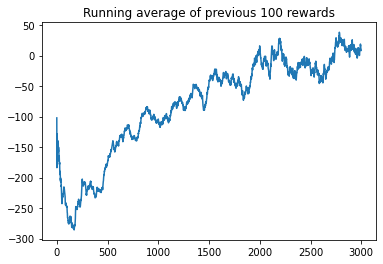

In [28]:
running_avg = np.zeros(len(total_rewards))

for i in range(len(running_avg)):
    running_avg[i] = np.mean(total_rewards[max(0, i-100):(i+1)])
    
plt.plot(running_avg)
plt.title('Running average of previous 100 rewards')
plt.show()

In [22]:
reload = True  # 저장된 모델 사용시  True 로 변경
if reload:
    model = ActorCritic(env.observation_space.shape, n_actions).to(device)                        
    model.load_state_dict(torch.load('253_ActorCritic_LunarLander-v2.pth'))

### Animate it with Video

In [23]:
display = Display(visible=False, size=(1400, 900))
_ = display.start()

def render_mp4(videopath: str) -> str:
  """
  지정된 경로에 있는 MP4 비디오의 b4 인코딩 버전을 포함하는 문자열을 가져옵니다.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [24]:
file = "notrain.mp4"
video = VideoRecorder(env, file)

# 시각화
state = env.reset()
for _ in range(500):
    env.render()
    video.capture_frame()
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

env.close()
video.close()

In [25]:
file = "train.mp4"
video = VideoRecorder(env, file)

# 시각화
state = env.reset()
while True:
    env.render()
    video.capture_frame()
    
    state_t = torch.FloatTensor(state).to(device)
    with torch.no_grad():
        probs = model.pi(state_t).detach().cpu().numpy()
        action = np.random.choice(action_space, p=probs)

    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break

env.close()
video.close()

In [26]:
# file = "notrain.mp4"
file = "train.mp4"

html = render_mp4(file)
HTML(html)